In [284]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score


import scipy.stats as scs
import statsmodels.api as sm


%matplotlib inline

##### Read in the Data

In [190]:
raw_data = pd.read_csv('/Users/brandonmojica/Desktop/Galvanize/Capstones/Capstone_2/stockx_price_predict/data/StockX-Data-2019.csv')

##### Quick pass of the data to get an idea of what we are dealing with. 

In [191]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 8 columns):
Order Date      99956 non-null object
Brand           99956 non-null object
Sneaker Name    99956 non-null object
Sale Price      99956 non-null object
Retail Price    99956 non-null object
Release Date    99956 non-null object
Shoe Size       99956 non-null float64
Buyer Region    99956 non-null object
dtypes: float64(1), object(7)
memory usage: 6.1+ MB


In [192]:
raw_data.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2/11/17,11.0,Rhode Island


#### Data Cleaning Pt 1: Remove the dollar signs for columns sale price and retial price

In [193]:
#Create a copy of the data just for backup
stockx_data = raw_data.copy()

In [194]:
def remove_unwanted_chars(string):
    
    """
    Inputs: string
    
    Description: A function that removes the "$" and "," and converts the string into an integer

    Returns: int
    
    """
    string = string.strip('$')
    string = string.replace(',','')
    string = int(string)
    
    return string

In [195]:
#Use the function remove_unwanted_chars to remove $ and ,
stockx_data['Retail Price'] = stockx_data['Retail Price'].apply(remove_unwanted_chars)

In [196]:
stockx_data['Sale Price'] = stockx_data['Sale Price'].apply(remove_unwanted_chars)

In [197]:
stockx_data.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2/11/17,11.0,Rhode Island


In [198]:
#covert the order date to a datetime type. 
stockx_data['Order Date'] = stockx_data['Order Date'].astype('datetime64[ns]') 

In [199]:
stockx_data['Release Date'] = stockx_data['Release Date'].astype('datetime64[ns]') 

In [200]:
stockx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 8 columns):
Order Date      99956 non-null datetime64[ns]
Brand           99956 non-null object
Sneaker Name    99956 non-null object
Sale Price      99956 non-null int64
Retail Price    99956 non-null int64
Release Date    99956 non-null datetime64[ns]
Shoe Size       99956 non-null float64
Buyer Region    99956 non-null object
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 6.1+ MB


In [201]:
stockx_data.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2017-02-11,11.0,Rhode Island


In [202]:
#convert the the order date into sperate cols 
stockx_data['Order year'] = stockx_data['Order Date'].dt.year 
stockx_data['Order month'] = stockx_data['Order Date'].dt.month 
stockx_data['Order day'] = stockx_data['Order Date'].dt.day

In [203]:
#convert the the release date into sperate cols 
stockx_data['Release year'] = stockx_data['Release Date'].dt.year 
stockx_data['Release month'] = stockx_data['Release Date'].dt.month 
stockx_data['Release day'] = stockx_data['Release Date'].dt.day

In [210]:
stockx_data.rename(columns={'Sneaker Name':'shoe'},inplace=True)

In [211]:
stockx_data.tail()

,Order Date,Brand,shoe,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Order year,Order month,Order day,Release year,Release month,Release day
99951,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,565,220,2018-12-26,8.0,Oregon,2019,2,13,2018,12,26
99952,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,598,220,2018-12-26,8.5,California,2019,2,13,2018,12,26
99953,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,605,220,2018-12-26,5.5,New York,2019,2,13,2018,12,26
99954,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,650,220,2018-12-26,11.0,California,2019,2,13,2018,12,26
99955,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,640,220,2018-12-26,11.5,Texas,2019,2,13,2018,12,26


In [212]:
#How many unique types of shoes are there
len(stockx_data['shoe'].unique())

50

In [213]:
#How many unique types of shoes are there
stockx_data['Brand'].unique()

array([' Yeezy', 'Off-White'], dtype=object)

In [214]:
stockx_data['shoe'].unique()

array(['Adidas-Yeezy-Boost-350-Low-V2-Beluga',
       'Adidas-Yeezy-Boost-350-V2-Core-Black-Copper',
       'Adidas-Yeezy-Boost-350-V2-Core-Black-Green',
       'Adidas-Yeezy-Boost-350-V2-Core-Black-Red',
       'Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017',
       'Adidas-Yeezy-Boost-350-V2-Core-Black-White',
       'Adidas-Yeezy-Boost-350-V2-Cream-White',
       'Adidas-Yeezy-Boost-350-V2-Zebra',
       'Adidas-Yeezy-Boost-350-Low-Moonrock', 'Nike-Air-Max-90-Off-White',
       'Nike-Air-Presto-Off-White', 'Nike-Air-VaporMax-Off-White',
       'Air-Jordan-1-Retro-High-Off-White-Chicago',
       'Nike-Blazer-Mid-Off-White',
       'Adidas-Yeezy-Boost-350-Low-Pirate-Black-2016',
       'Adidas-Yeezy-Boost-350-Low-Oxford-Tan',
       'Adidas-Yeezy-Boost-350-Low-Turtledove',
       'Adidas-Yeezy-Boost-350-Low-Pirate-Black-2015',
       'Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow',
       'Nike-Air-Force-1-Low-Off-White', 'Nike-Air-Max-97-Off-White',
       'Nike-Air-Force-1-Low-Virgil

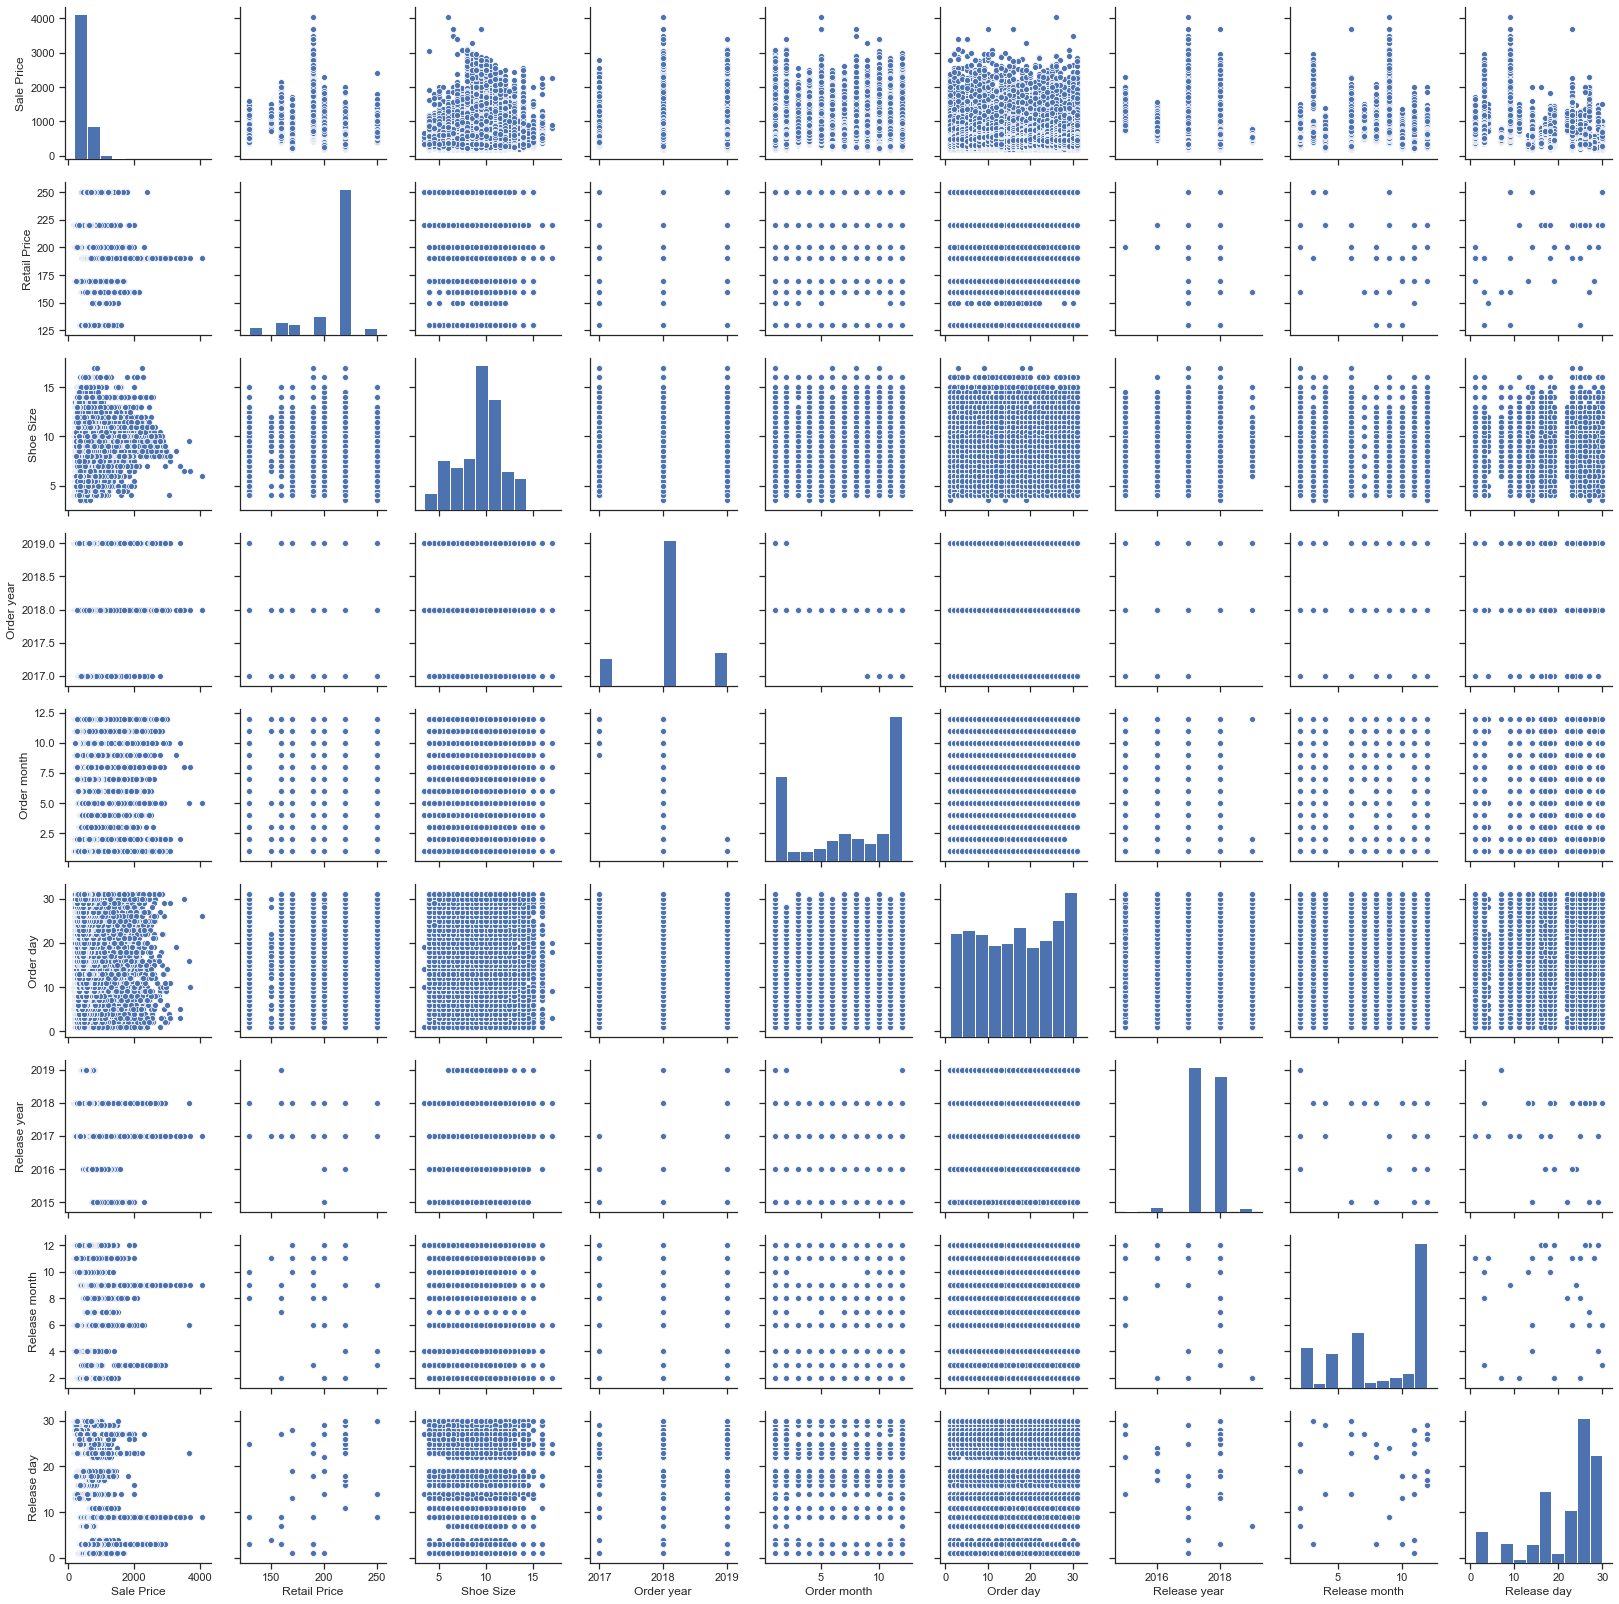

In [20]:
sns.set(style="ticks")
sns.pairplot(stockx_data)

In [81]:
stockx_data.groupby('Shoe Size')['Order Date'].count()

Shoe Size
3.5         4
4.0      2241
4.5      1304
5.0      3577
5.5      2621
6.0      4013
6.5      2219
7.0      3867
7.5      2664
8.0      5363
8.5      5300
9.0      9706
9.5      8685
10.0    11093
10.5     8784
11.0     9251
11.5     4502
12.0     7297
12.5      628
13.0     4602
13.5      147
14.0     1791
14.5       84
15.0      130
16.0       79
17.0        4
Name: Order Date, dtype: int64

In [215]:
states = stockx_data.groupby('Buyer Region')['Order Date'].count().sort_values(ascending=False)

In [216]:
states_counts_df = states.to_frame()

In [217]:
states_counts_df.reset_index(inplace=True)

In [218]:
states_counts_df.rename(columns={'Order Date':'counts','Buyer Region':'states'},inplace=True)

In [219]:
states_counts_df

,states,counts
0,California,19349
1,New York,16525
2,Oregon,7681
3,Florida,6376
4,Texas,5876
5,New Jersey,4720
6,Illinois,3782
7,Pennsylvania,3109
8,Massachusetts,2903
9,Michigan,2762


In [220]:
top_20_states = states_counts_df[0:21]

In [221]:
top_20_states

,states,counts
0,California,19349
1,New York,16525
2,Oregon,7681
3,Florida,6376
4,Texas,5876
5,New Jersey,4720
6,Illinois,3782
7,Pennsylvania,3109
8,Massachusetts,2903
9,Michigan,2762


[Text(0, 0, 'California'),
 Text(0, 0, 'New York'),
 Text(0, 0, 'Oregon'),
 Text(0, 0, 'Florida'),
 Text(0, 0, 'Texas'),
 Text(0, 0, 'New Jersey'),
 Text(0, 0, 'Illinois'),
 Text(0, 0, 'Pennsylvania'),
 Text(0, 0, 'Massachusetts'),
 Text(0, 0, 'Michigan'),
 Text(0, 0, 'Virginia'),
 Text(0, 0, 'Ohio'),
 Text(0, 0, 'Maryland'),
 Text(0, 0, 'Washington'),
 Text(0, 0, 'Georgia'),
 Text(0, 0, 'Arizona'),
 Text(0, 0, 'North Carolina'),
 Text(0, 0, 'Delaware'),
 Text(0, 0, 'Connecticut'),
 Text(0, 0, 'Indiana'),
 Text(0, 0, 'Colorado')]

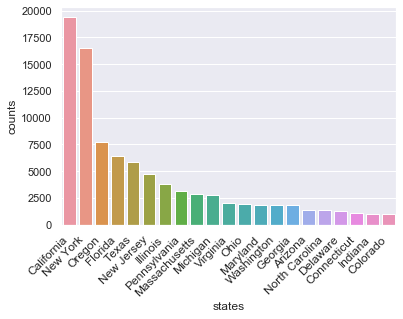

In [222]:
chart = sns.barplot(x='states', y= 'counts', data = top_20_states)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large')

In [32]:
top_10_states = states_counts_df[0:11]

[Text(0, 0, 'California'),
 Text(0, 0, 'New York'),
 Text(0, 0, 'Oregon'),
 Text(0, 0, 'Florida'),
 Text(0, 0, 'Texas'),
 Text(0, 0, 'New Jersey'),
 Text(0, 0, 'Illinois'),
 Text(0, 0, 'Pennsylvania'),
 Text(0, 0, 'Massachusetts'),
 Text(0, 0, 'Michigan'),
 Text(0, 0, 'Virginia')]

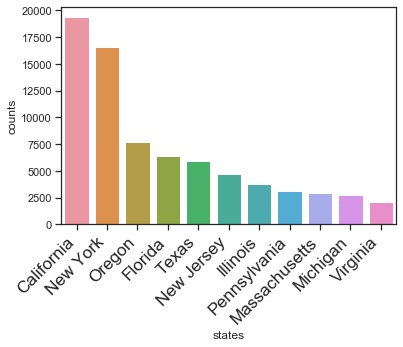

In [33]:
chart = sns.barplot(x='states', y= 'counts', data = top_10_states)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')

In [128]:
sneakers = stockx_data.groupby('shoe')['Order Date'].count().sort_values(ascending=False)

In [139]:
sneakers.to_frame()

,Order Date
shoe,
adidas-Yeezy-Boost-350-V2-Butter,11423
Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,10395
Adidas-Yeezy-Boost-350-V2-Zebra,10110
Adidas-Yeezy-Boost-350-V2-Blue-Tint,9297
Adidas-Yeezy-Boost-350-V2-Cream-White,9097
Adidas-Yeezy-Boost-350-V2-Sesame,5553
adidas-Yeezy-Boost-350-V2-Static,4983
Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow,4854
Air-Jordan-1-Retro-High-Off-White-University-Blue,4635


In [140]:
top_10_sneakers = sneakers[0:11]

In [141]:
top_10_df = top_10_sneakers.to_frame()

In [142]:
top_10_df.rename(columns={'Order Date':'counts'},inplace=True)

In [170]:
top_10_df

,shoe,counts
0,adidas-Yeezy-Boost-350-V2-Butter,11423
1,Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,10395
2,Adidas-Yeezy-Boost-350-V2-Zebra,10110
3,Adidas-Yeezy-Boost-350-V2-Blue-Tint,9297
4,Adidas-Yeezy-Boost-350-V2-Cream-White,9097
5,Adidas-Yeezy-Boost-350-V2-Sesame,5553
6,adidas-Yeezy-Boost-350-V2-Static,4983
7,Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow,4854
8,Air-Jordan-1-Retro-High-Off-White-University-Blue,4635
9,adidas-Yeezy-Boost-350-V2-Static-Reflective,3184


In [169]:
top_10_df.reset_index(inplace=True)

[Text(0, 0, 'adidas-Yeezy-Boost-350-V2-Butter'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Beluga-2pt0'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Zebra'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Blue-Tint'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Cream-White'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Sesame'),
 Text(0, 0, 'adidas-Yeezy-Boost-350-V2-Static'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow'),
 Text(0, 0, 'Air-Jordan-1-Retro-High-Off-White-University-Blue'),
 Text(0, 0, 'adidas-Yeezy-Boost-350-V2-Static-Reflective'),
 Text(0, 0, 'Nike-Air-Presto-Off-White-Black-2018')]

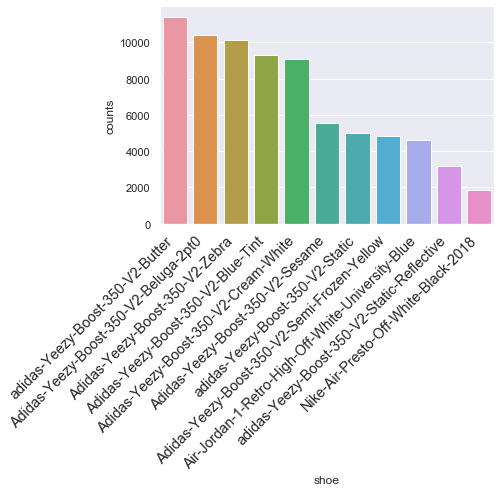

In [171]:
chart = sns.barplot(x='shoe', y= 'counts', data = top_10_df)

chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')

In [176]:
test_txt = 'Adidas-Yeezy-Boost-350-Low-V2-Beluga'
test_txt.split('-')

['Adidas', 'Yeezy', 'Boost', '350', 'Low', 'V2', 'Beluga']

In [235]:
stockx_data.head()

,Order Date,Brand,shoe,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Order year,Order month,Order day,Release year,Release month,Release day,mark_up
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,2016-09-24,11.0,California,2017,9,1,2016,9,24,877
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,465
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,470
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,2016-11-23,11.5,Kentucky,2017,9,1,2016,11,23,855
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2017-02-11,11.0,Rhode Island,2017,9,1,2017,2,11,608


In [224]:
stockx_data['Order year'].unique()

array([2017, 2018, 2019])

In [225]:
stockx_data['Release year'].unique()

array([2016, 2017, 2015, 2018, 2019])

## Computed the mark up of a shoe and placed into it's own column

In [226]:
stockx_data['mark_up'] = stockx_data['Sale Price'] - stockx_data['Retail Price']

In [227]:
stockx_data.describe()

,Sale Price,Retail Price,Shoe Size,Order year,Order month,Order day,Release year,Release month,Release day,mark_up
count,99956.000000,99956.00000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000
mean,446.634719,208.61359,9.344181,2018.029013,7.532654,16.150686,2017.467246,8.052243,21.673696,238.021129
std,255.982969,25.20001,2.329588,0.542357,4.089962,9.085088,0.579352,3.612667,7.805765,266.133179
min,186.000000,130.00000,3.500000,2017.000000,1.000000,1.000000,2015.000000,2.000000,1.000000,-34.000000
25%,275.000000,220.00000,8.000000,2018.000000,3.000000,8.000000,2017.000000,6.000000,16.000000,58.000000
50%,370.000000,220.00000,9.500000,2018.000000,8.000000,16.000000,2017.000000,9.000000,25.000000,154.000000
75%,540.000000,220.00000,11.000000,2018.000000,11.000000,24.000000,2018.000000,11.000000,27.000000,342.000000
max,4050.000000,250.00000,17.000000,2019.000000,12.000000,31.000000,2019.000000,12.000000,30.000000,3860.000000


In [228]:
stockx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 15 columns):
Order Date       99956 non-null datetime64[ns]
Brand            99956 non-null object
shoe             99956 non-null object
Sale Price       99956 non-null int64
Retail Price     99956 non-null int64
Release Date     99956 non-null datetime64[ns]
Shoe Size        99956 non-null float64
Buyer Region     99956 non-null object
Order year       99956 non-null int64
Order month      99956 non-null int64
Order day        99956 non-null int64
Release year     99956 non-null int64
Release month    99956 non-null int64
Release day      99956 non-null int64
mark_up          99956 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(9), object(3)
memory usage: 11.4+ MB


## Create the dummies for the categorical columns

In [229]:
shoe_dummy = pd.get_dummies(stockx_data['Shoe Size'])

In [230]:
shoe_dummy

,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,...,11.5,12.0,12.5,13.0,13.5,14.0,14.5,15.0,16.0,17.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
99952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99953,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99954,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [239]:
release_year_data_dummy = pd.get_dummies(stockx_data['Release year'])

In [240]:
release_year_data_dummy.head()

,2015,2016,2017,2018,2019
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,0,1,0,0


In [241]:
brand_dummy = pd.get_dummies(stockx_data['Brand'])

In [242]:
brand_dummy

,Yeezy,Off-White
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
99951,1,0
99952,1,0
99953,1,0
99954,1,0


In [245]:
state_dummy = pd.get_dummies(stockx_data['Buyer Region'])

In [246]:
state_dummy

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99952,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99954,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [255]:
order_month_dummy = pd.get_dummies(stockx_data['Order month'])

In [257]:
order_day_dummy = pd.get_dummies(stockx_data['Order day'])

In [269]:
order_year_dummy = pd.get_dummies(stockx_data['Order year'])

In [259]:
release_month_dummy = pd.get_dummies(stockx_data['Release month'])

In [260]:
release_day_dummy = pd.get_dummies(stockx_data['Release day'])

In [264]:
shoe_type_dummy = pd.get_dummies(stockx_data['shoe'])

In [275]:
dummy_df = pd.concat([stockx_data,shoe_dummy,release_year_data_dummy,brand_dummy,state_dummy,order_month_dummy,order_month_dummy,order_day_dummy,release_month_dummy,release_day_dummy,shoe_type_dummy,order_year_dummy], axis=1)







In [243]:
stockx_data.head()

,Order Date,Brand,shoe,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Order year,Order month,Order day,Release year,Release month,Release day,mark_up
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,2016-09-24,11.0,California,2017,9,1,2016,9,24,877
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,465
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,470
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,2016-11-23,11.5,Kentucky,2017,9,1,2016,11,23,855
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2017-02-11,11.0,Rhode Island,2017,9,1,2017,2,11,608


In [277]:
dummy_df.drop(columns=['Brand','Shoe Size','Buyer Region','Release Date','shoe','Release year','Release month','Release day','Order year','Order month','Order day'],inplace=True)

KeyError: "['Brand' 'Shoe Size' 'Buyer Region' 'Release Date' 'shoe' 'Release year'\n 'Release month' 'Release day' 'Order year' 'Order month' 'Order day'] not found in axis"

In [280]:
dummy_df.drop(columns=['Order Date'],inplace=True)

In [282]:
target = dummy_df['Sale Price'] 

In [286]:
# X = sm.add_constant(X)
# model = sm.OLS(y, X).fit()
# summary = model.summary()


X = dummy_df.copy()
y = X.pop('Sale Price')

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
summary = model.summary()

    
# summary_model(X, y)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [287]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sale Price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.331e+31
Date:                Mon, 03 Feb 2020   Prob (F-statistic):               0.00
Time:                        12:31:58   Log-Likelihood:             2.5664e+06
No. Observations:               99956   AIC:                        -5.133e+06
Df Residuals:                   99787   BIC:                        -5.131e+06
Df Model:                         168                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                                 0.0023    2.9e-14   8.01e+10      0.000       0.002       0.002
Retail Price                                          1.0000   3.31e-16   3.02e+15      0.000       1.000       1.000
mark_up                                               1.0000   5.48e-17   1.82e+16      0.000       1.000       1.000
3.5                                                8.923e-05   8.25e-13   1.08e+08      0.000    8.92e-05    8.92e-05
4.0                                                8.923e-05   5.97e-14   1.49e+09      0.000    8.92e-05    8.92e-05
4.5                                                8.923e-05   6.66e-14   1.34e+09      0.000    8.92e-05    8.92e-05
5.0                                                8.923e-05   5.57e-14    1.6e+09      0.000    8.92e-05    8.92e-05
5.5                                                8.923e-05   5.82e-14   1.53e+09      0.000    8.92e-05    8.92e-05
6.0                                                8.923e-05   5.49e-14   1.63e+09      0.000    8.92e-05    8.92e-05
6.5                                                8.923e-05   5.97e-14    1.5e+09      0.000    8.92e-05    8.92e-05
7.0                                                8.923e-05   5.52e-14   1.62e+09      0.000    8.92e-05    8.92e-05
7.5                                                8.923e-05   5.79e-14   1.54e+09      0.000    8.92e-05    8.92e-05
8.0                                                8.923e-05   5.33e-14   1.67e+09      0.000    8.92e-05    8.92e-05
8.5                                                8.923e-05   5.34e-14   1.67e+09      0.000    8.92e-05    8.92e-05
9.0                                                8.923e-05   5.12e-14   1.74e+09      0.000    8.92e-05    8.92e-05
9.5                                                8.923e-05   5.15e-14   1.73e+09      0.000    8.92e-05    8.92e-05
10.0                                               8.923e-05   5.08e-14   1.76e+09      0.000    8.92e-05    8.92e-05
10.5                                               8.923e-05   5.14e-14   1.73e+09      0.000    8.92e-05    8.92e-05
11.0                                               8.923e-05   5.13e-14   1.74e+09      0.000    8.92e-05    8.92e-05
11.5                                               8.923e-05   5.42e-14   1.65e+09      0.000    8.92e-05    8.92e-05
12.0                                               8.923e-05   5.21e-14   1.71e+09      0.000    8.92e-05    8.92e-05
12.5                                               8.923e-05   8.16e-14   1.09e+09      0.000    8.92e-05    8.92e-05
13.0                                               8.923e-05   5.41e-14   1.65e+09      0.000    8.92e-05    8.92e-05
13.5           

In [283]:
dummy_df

,Sale Price,Retail Price,mark_up,3.5,4.0,4.5,5.0,5.5,6.0,6.5,...,Nike-Zoom-Fly-Mercurial-Off-White-Total-Orange,Nike-Zoom-Fly-Off-White,Nike-Zoom-Fly-Off-White-Black-Silver,Nike-Zoom-Fly-Off-White-Pink,adidas-Yeezy-Boost-350-V2-Butter,adidas-Yeezy-Boost-350-V2-Static,adidas-Yeezy-Boost-350-V2-Static-Reflective,2017,2018,2019
0,1097,220,877,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,685,220,465,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,690,220,470,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1075,220,855,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,828,220,608,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,565,220,345,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
99952,598,220,378,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
99953,605,220,385,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
99954,650,220,430,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
